In [57]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 12 -t 100:00:00 -p priority  ./ctct_run_all.py
# Tesla M40
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from baseline.immnue_score import immnue_score_methods
from conceptor.utils import plot_embed_with_label,plot_performance, score, score2
from conceptor import PreTrainer, FineTuner, loadconceptor

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [58]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from baseline.immnue_score import immnue_score_methods
from conceptor.utils import plot_embed_with_label,plot_performance, score
from conceptor.tokenizer import CANCER_CODE

data_path = '../../../../paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))
df_tpm.shape, df_label.shape

df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n = " + size.astype(str) + ")"
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()
#cohorts

In [59]:
dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
pretrainer = loadconceptor('../../../checkpoint/latest/pretrainer.pt')

In [60]:
df_c2c = pd.read_csv('../stratification/cancer2cancer.csv', index_col=0)
df_d2d = pd.read_csv('../stratification/drug2drug.csv', index_col=0)
df_s2s = pd.read_csv('../stratification/sequencer2sequencer.csv', index_col=0)

df_label = pd.concat([df_c2c, df_d2d, df_s2s])
cohorts = df_label['stratified_cohort'].unique().tolist()
cohort_rgc = df_label[['stratified_cohort', 'stratified_cohort_rgc']].drop_duplicates().set_index('stratified_cohort').stratified_cohort_rgc.to_dict()

In [61]:
cohort_target_map = df_label[['stratified_cohort', 'ICI_target_map']].drop_duplicates().set_index('stratified_cohort').ICI_target_map.to_dict()
cohort_cancer_map = df_label[['stratified_cohort', 'cancer_type']].drop_duplicates().set_index('stratified_cohort').cancer_type.to_dict()

def cohort_to_cohort(cohorts):
    # Create a list of lists, each missing one element from the original list
    return [(cohorts[i], cohorts[:i] + cohorts[i+1:]) for i in range(len(cohorts))]
# train_test_cohorts = cohort_to_cohort(cohorts)

In [62]:
# df_label = df_label[df_label.domain == 'sequencer2sequencer']
transfer_groups = df_label.groupby(['domain', 'group'])['stratified_cohort'].unique().apply(lambda x:x.tolist())

train_test_cohorts = []
domains = []
groups = []
for (domain, group), transfer_cohots in transfer_groups.items():
    transfer_pairs = cohort_to_cohort(transfer_cohots)
    for pair in transfer_pairs:
        domains.append(domain)
        groups.append(group)
        train_test_cohorts.append(pair)

In [63]:
params = {'mode': 'PFT',
        'seed':42,
        'lr': 1e-2,
        'device':'cuda',
        'weight_decay': 1e-1,
        'batch_size':8,
        'max_epochs': 10,
        'task_loss_weight':1,
        'load_decoder':False,
        'task_loss_type': 'ce_loss', 
        'task_type': 'c',
        'task_dense_layer': [16],
        'task_batch_norms':True,
        'entropy_weight': 0.0,
        'with_wandb': False,
        'save_best_model':False,
        'verbose': False}

Evaluation on Model PFT


 90%|######### | 9/10 [00:17<00:01,  1.93s/it]

Stopping early at epoch 10. Meet minimal requirements by: f1=0.92,mcc=0.88,prc=0.98, roc=0.99



 90%|######### | 9/10 [00:20<00:02,  2.31s/it]

Stopping early at epoch 10. Meet minimal requirements by: f1=1.00,mcc=1.00,prc=1.00, roc=1.00



 80%|########  | 8/10 [00:21<00:05,  2.63s/it]

Stopping early at epoch  9. Meet minimal requirements by: f1=0.92,mcc=0.87,prc=0.96, roc=0.98



 90%|######### | 9/10 [00:12<00:01,  1.36s/it]

Stopping early at epoch 10. Meet minimal requirements by: f1=0.91,mcc=0.87,prc=1.00, roc=1.00



 80%|########  | 8/10 [00:22<00:05,  2.82s/it]

Stopping early at epoch  9. Meet minimal requirements by: f1=0.95,mcc=0.94,prc=0.94, roc=0.99



100%|##########| 6/6 [00:00<00:00, 10.55it/s]


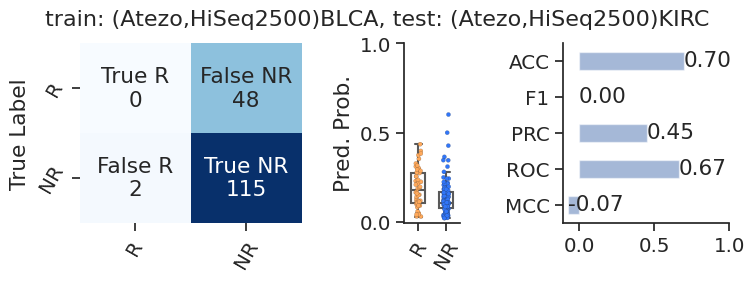

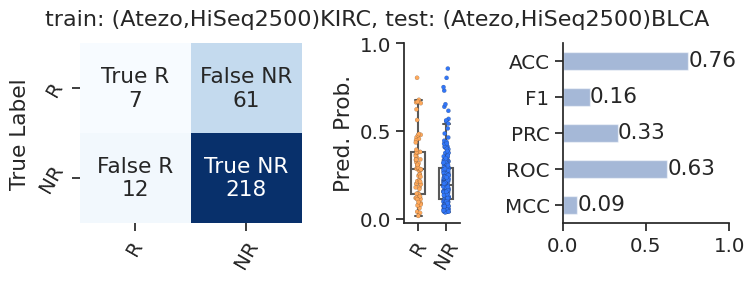

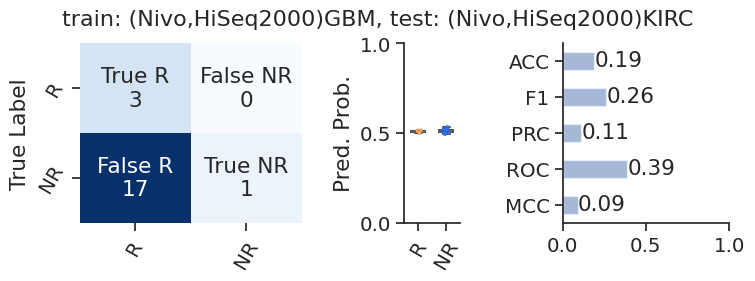

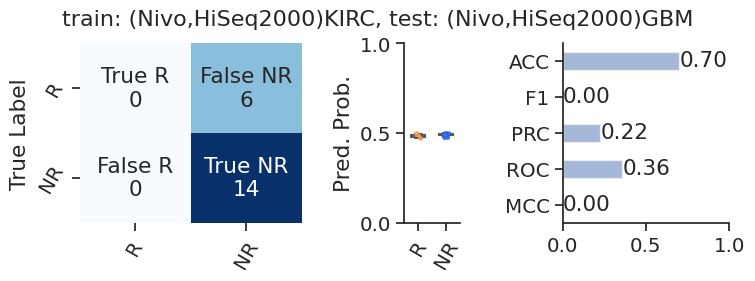

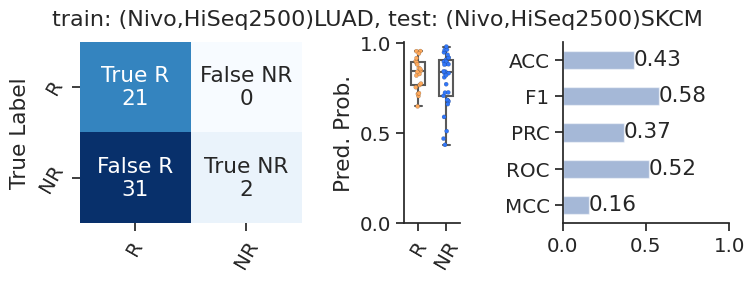

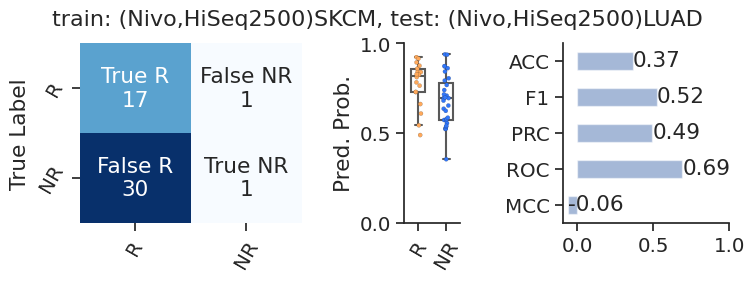

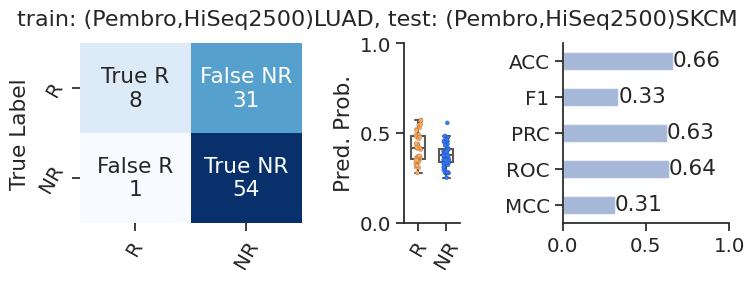

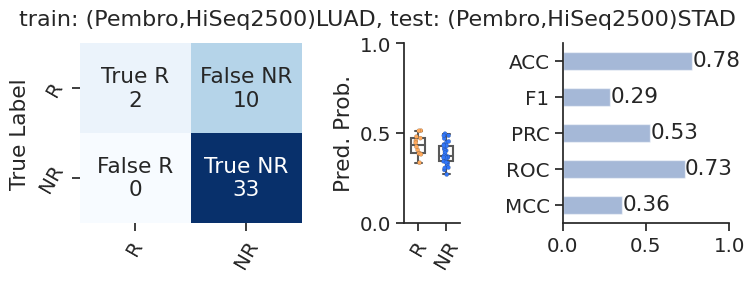

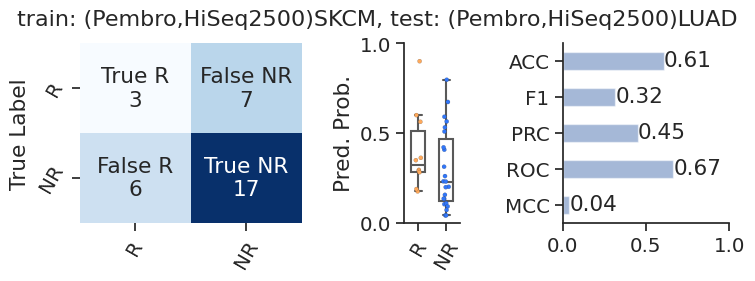

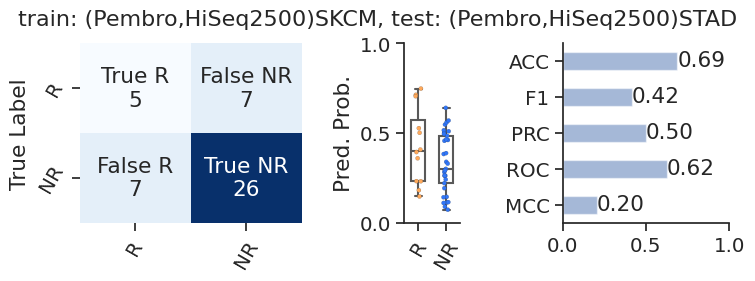

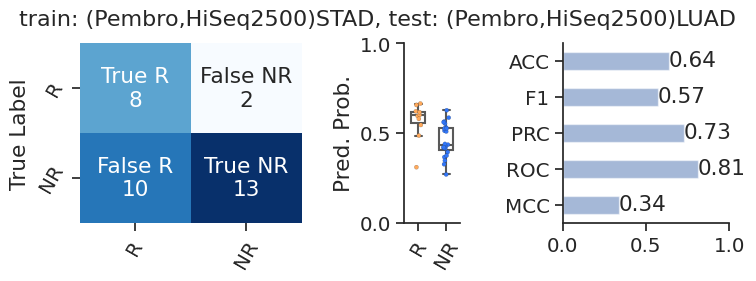

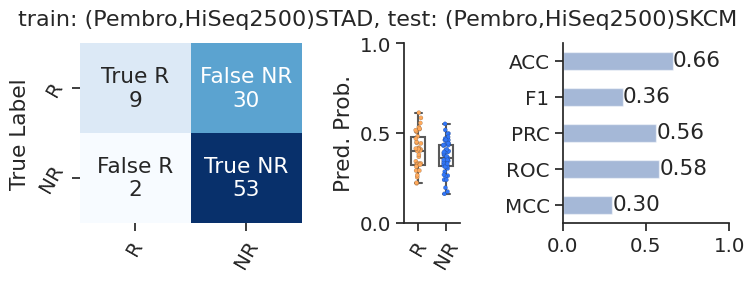

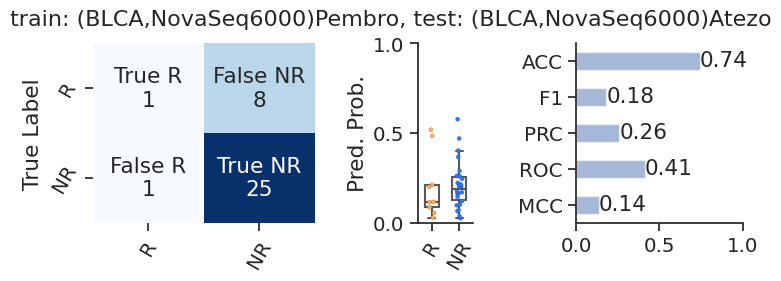

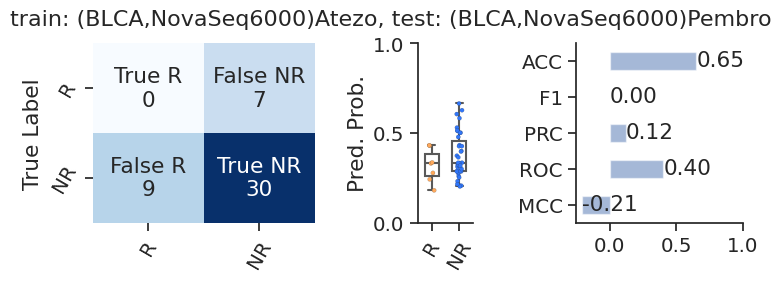

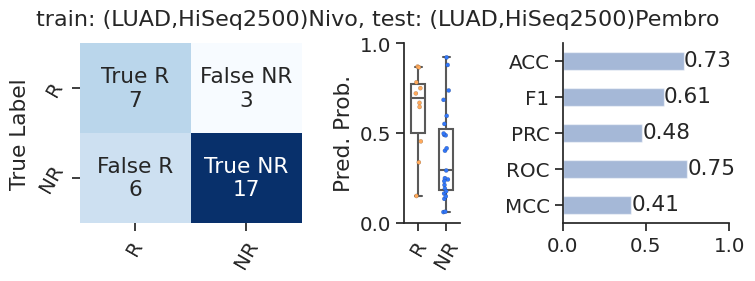

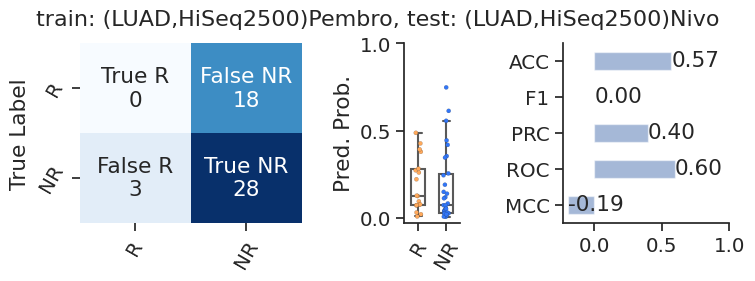

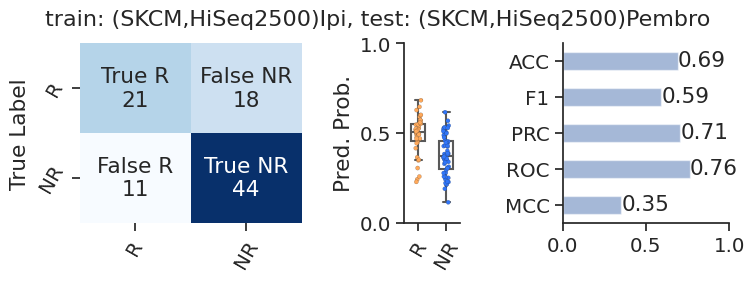

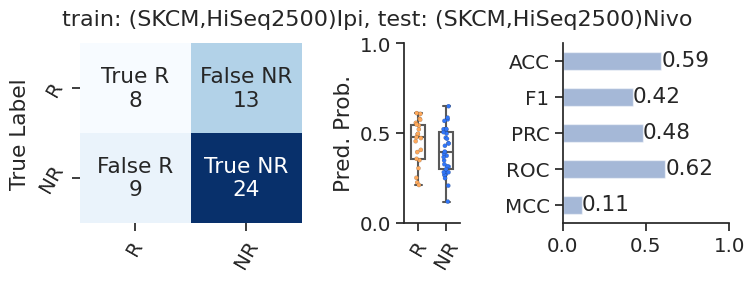

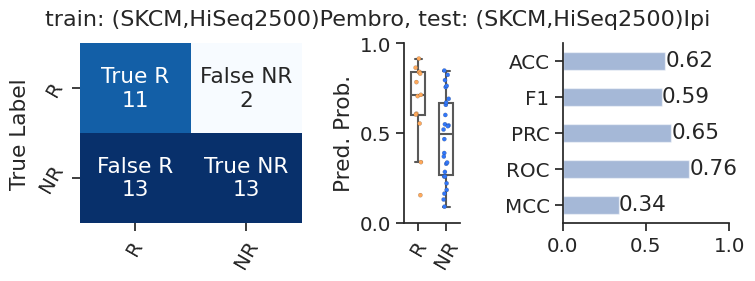

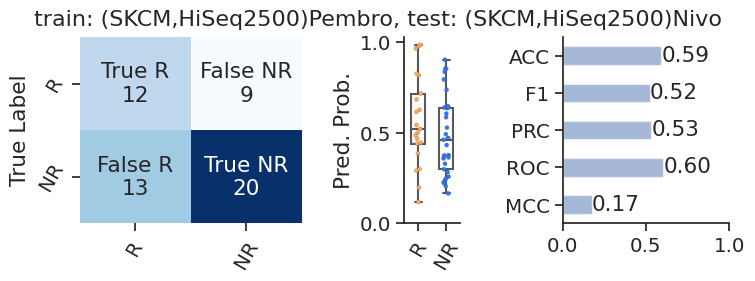

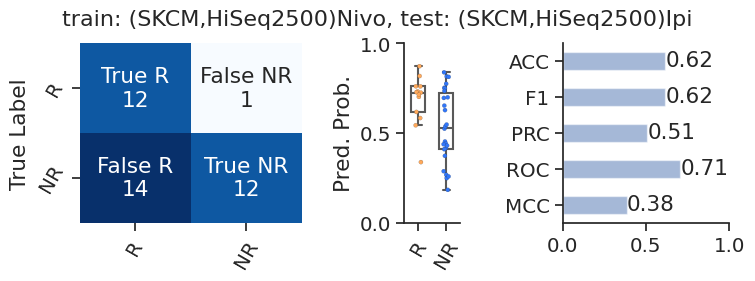

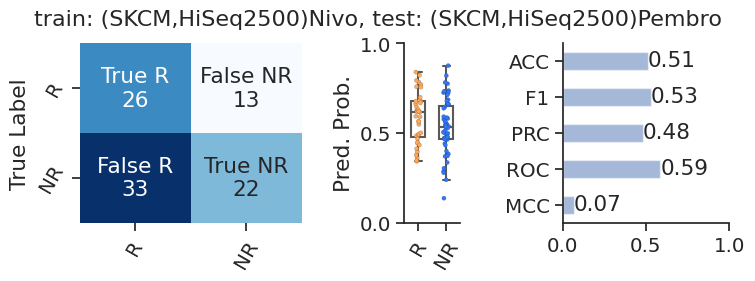

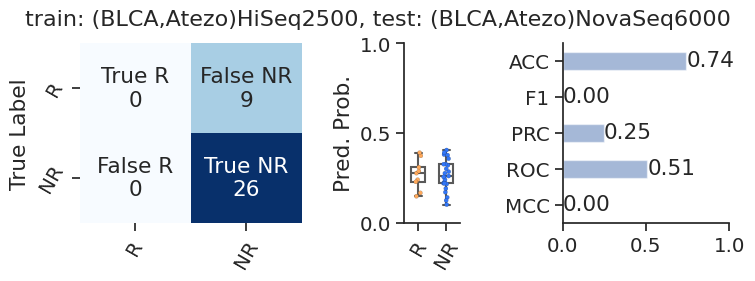

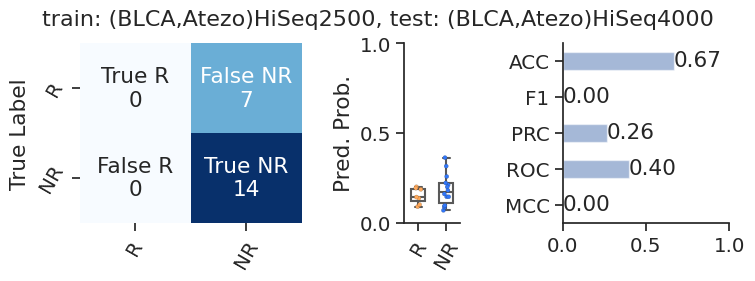

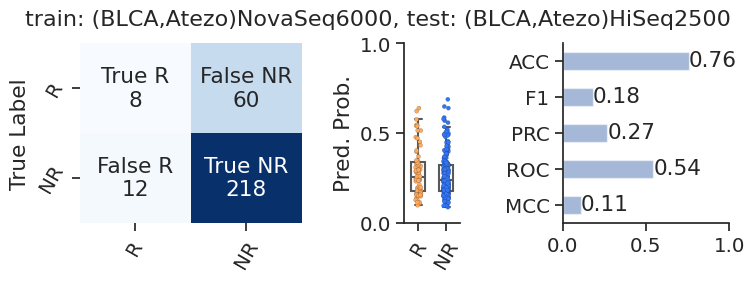

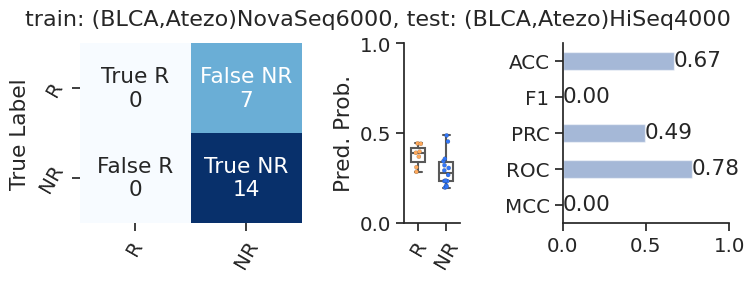

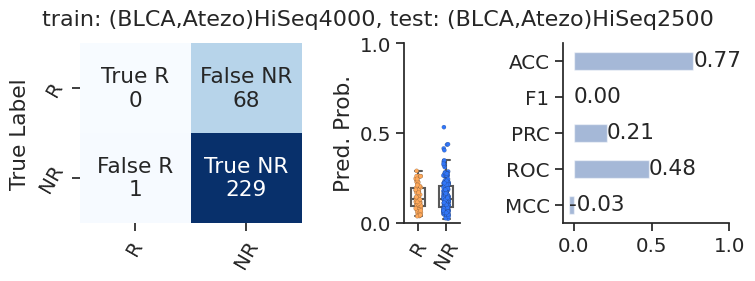

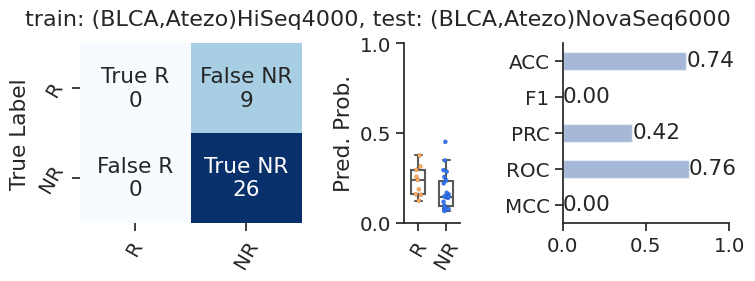

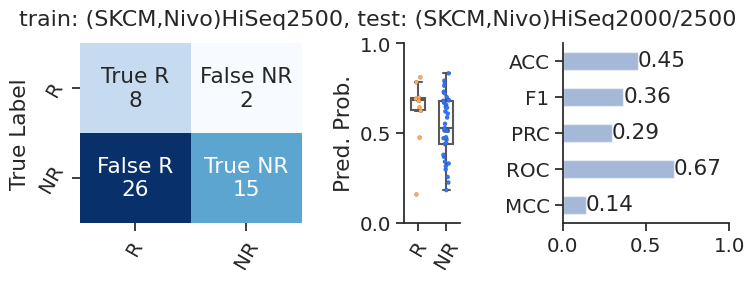

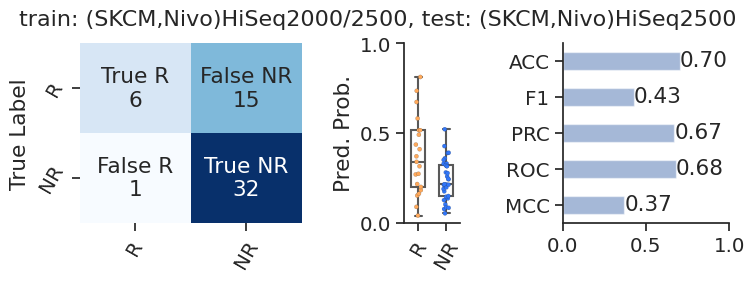

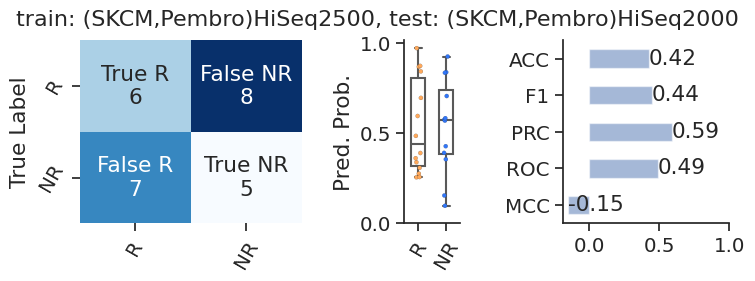

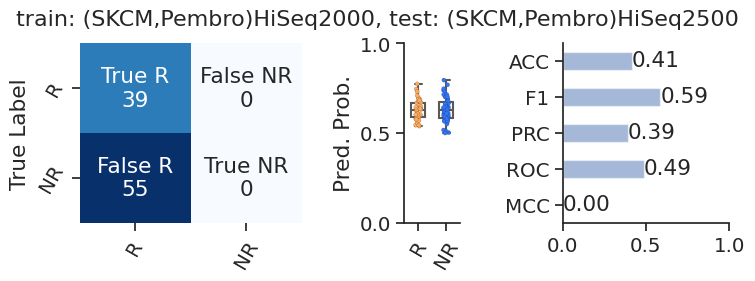

In [64]:
for mode in ['PFT']:
    
    print('Evaluation on Model %s' % mode)

    work_dir = './F2F/F2F_%s' % (mode)
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)

    res = []
    for (train_cohort, test_cohorts), domain, group in zip(train_test_cohorts, domains, groups):
        
        ## Get data for this cohort
        cohort_idx = df_label[df_label['stratified_cohort'] == train_cohort].index
        train_X = dfcx.loc[cohort_idx]
        train_y = df_task.loc[cohort_idx]

        params['mode'] = mode

        if domain == 'cancer2cancer':
            params['batch_size'] = 16
        else:
            params['batch_size'] = 8
            
        pretrainer = pretrainer.copy()
        finetuner = FineTuner(pretrainer, **params, 
                              work_dir= work_dir, 
                              task_name = '%s' % train_cohort,
                              )
        
        finetuner = finetuner.tune(dfcx_train = train_X,
                                   dfy_train = train_y, 
                                   min_mcc=0.8)
        

        for test_cohort in test_cohorts:
            test_cohort_idx = df_label[df_label['stratified_cohort'] == test_cohort].index
            test_cohort_X = dfcx.loc[test_cohort_idx]
            test_cohort_y = df_task.loc[test_cohort_idx]
            
            _, pred_testy = finetuner.predict(test_cohort_X, batch_size = 16)

            pred_testy['domain'] = domain
            pred_testy['group'] = group
            pred_testy['train_cohort'] = train_cohort
            pred_testy['test_cohort'] = test_cohort    
            pred_testy['test_cohort_rgc'] = cohort_rgc[test_cohort]

            pred_testy['best_epoch'] = finetuner.best_epoch
            pred_testy['n_trainable_params'] = finetuner.count_parameters()
            pred_testy['mode'] = mode
            pred_testy['seed'] = params['seed']
            pred_testy['batch_size'] = params['batch_size']
            pred_testy['task_dense_layer'] = str(params['task_dense_layer'])
            dfp = test_cohort_y.join(pred_testy)

            y_true, y_prob, y_pred = dfp['R'], dfp[1], dfp[[0, 1]].idxmax(axis=1)
            fig = plot_performance(y_true, y_prob, y_pred)
            fig.suptitle('train: %s, test: %s' % (train_cohort, test_cohort), fontsize=16)
            fig.savefig(os.path.join(work_dir, 'CTCT_train_%s_test_%s.jpg' % (train_cohort.replace('/', ':'), test_cohort.replace('/', ':'))))
            res.append(dfp)
    
    dfs = pd.concat(res)
    dfp = dfs.groupby(['domain','group','train_cohort', 
                       'test_cohort', 'mode', 'best_epoch',
                       'test_cohort_rgc']).apply(lambda x:score2(x['R'], x[1], x[[0, 1]].idxmax(axis=1)))
    
    #roc, prc, f1, acc, mcc
    dfp = dfp.apply(pd.Series)
    dfp.columns = ['ROC', 'PRC', 'F1', 'ACC', 'MCC']
    dfp = dfp.reset_index()

    dfs.to_csv(os.path.join(work_dir, 'source_performance.tsv'), sep='\t')
    dfp.to_csv(os.path.join(work_dir, 'metric_performance.tsv'), sep='\t')

In [65]:
ls

ctc_run_FFT.ipynb  ctc_run_NFT.ipynb  F2F/
ctc_run_LFT.ipynb  ctc_run_PFT.ipynb
